1) Logical outcomes vs encoded phases, rotations along bloch sphere plotting on graph (cyclical)

2) “Error injection” demo: one fault → what it becomes 
    a CZ-Z error,
    a spectator Z,
    a mover error
    Animation idea: show how it propagates through the circuit and whether it is detected by syndrome.
    Why it hits: explains dominance of channels with one memorable example.

3) Zone map animation: mover / sitter / spectator per moment
    Animation idea: each timestep:
        qubits in gate zone glow,
        spectators outlined,
        sitters dim,
        movers animate along paths.

4) Syndrome movie: stabilizers lighting up across QEC rounds
    triangular 7-qubit layout with the X/Z stabilizers (or parity checks) indicated
    Animation idea: for each QEC round:
    show measured syndrome bits as red/green indicators on checks,
    show post-selection: runs with nontrivial syndrome “fade out.”

5) Moment-by-moment (parallelism) Our circuits, and as you "move" through them in time, different noise occurs after gates, etc. Can also, optionally add the noise building up? 


In [41]:
from bloqade import squin
from kirin.dialects.ilist import IList
import numpy as np
import bloqade.stim
import bloqade.tsim

import sys, platform
import importlib
import shutil, subprocess


In [42]:
import numpy as np

def bits_to_pm1(samples: np.ndarray) -> np.ndarray:
    """
    Convert measurement bits {0,1} to eigenvalues {+1,-1}.
    Input:  samples shape (shots, n_qubits), dtype int/bool
    Output: same shape, dtype int, entries in {+1,-1}
    """
    s = samples.astype(np.int8)
    return 1 - 2*s  # 0->+1, 1->-1

def estimate_pauli_string(samples: np.ndarray, support=(0,1,5)):
    """
    Estimate <prod_{i in support} Z_i> from computational-basis samples.
    For X or Y measurements, you will basis-rotate before measuring Z,
    but this estimator stays the same.

    Returns: (mean, se, N)
    """
    pm1 = bits_to_pm1(samples)               # (N, n)
    parity = np.prod(pm1[:, support], axis=1)  # (N,) in {+1,-1}
    mean = float(np.mean(parity))
    N = parity.shape[0]
    # For ±1 variable: Var = 1 - mean^2. SE(mean) = sqrt(Var/N)
    se = float(np.sqrt(max(0.0, 1.0 - mean**2) / max(1, N)))
    return mean, se, N


In [43]:
import numpy as np
from bloqade import squin

SUPPORT = (0, 1, 5)

def MSD_encode_measure_Z(theta, phi):
    @squin.kernel
    def circ():
        q = squin.qalloc(7)
        squin.u3(theta, phi, 0, q[6])

        for i in range(6):
            squin.sqrt_y_adj(q[i])

        squin.cz(q[1], q[2])
        squin.cz(q[3], q[4])
        squin.cz(q[5], q[6])

        squin.sqrt_y(q[6])

        squin.cz(q[0], q[3])
        squin.cz(q[2], q[5])
        squin.cz(q[4], q[6])

        for i in range(5):
            squin.sqrt_y(q[i+2])

        squin.cz(q[0], q[1])
        squin.cz(q[2], q[3])
        squin.cz(q[4], q[5])

        squin.sqrt_y(q[1])
        squin.sqrt_y(q[2])
        squin.sqrt_y(q[4])

        squin.broadcast.measure(q)
    return circ


def MSD_encode_measure_X(theta, phi, support=SUPPORT):
    @squin.kernel
    def circ():
        q = squin.qalloc(7)
        squin.u3(theta, phi, 0, q[6])

        for i in range(6):
            squin.sqrt_y_adj(q[i])

        squin.cz(q[1], q[2])
        squin.cz(q[3], q[4])
        squin.cz(q[5], q[6])

        squin.sqrt_y(q[6])

        squin.cz(q[0], q[3])
        squin.cz(q[2], q[5])
        squin.cz(q[4], q[6])

        for i in range(5):
            squin.sqrt_y(q[i+2])

        squin.cz(q[0], q[1])
        squin.cz(q[2], q[3])
        squin.cz(q[4], q[5])

        squin.sqrt_y(q[1])
        squin.sqrt_y(q[2])
        squin.sqrt_y(q[4])

        # X-basis on support: H then measure Z
        for i in support:
            squin.h(q[i])

        squin.broadcast.measure(q)
    return circ


def MSD_encode_measure_Y(theta, phi, support=SUPPORT):
    @squin.kernel
    def circ():
        q = squin.qalloc(7)
        squin.u3(theta, phi, 0, q[6])

        for i in range(6):
            squin.sqrt_y_adj(q[i])

        squin.cz(q[1], q[2])
        squin.cz(q[3], q[4])
        squin.cz(q[5], q[6])

        squin.sqrt_y(q[6])

        squin.cz(q[0], q[3])
        squin.cz(q[2], q[5])
        squin.cz(q[4], q[6])

        for i in range(5):
            squin.sqrt_y(q[i+2])

        squin.cz(q[0], q[1])
        squin.cz(q[2], q[3])
        squin.cz(q[4], q[5])

        squin.sqrt_y(q[1])
        squin.sqrt_y(q[2])
        squin.sqrt_y(q[4])

        # Y-basis on support: S then H then measure Z
        for i in support:
            squin.s(q[i])
            squin.h(q[i])

        squin.broadcast.measure(q)
    return circ


In [44]:
import bloqade.tsim
import numpy as np

# - bits_to_pm1(samples)
# - estimate_pauli_string(samples, support=(0,1,5))

def sample_kernel(kernel, shots=2000):
    tsim_circ = bloqade.tsim.Circuit(kernel)
    sampler = tsim_circ.compile_sampler()
    return sampler.sample(shots=shots)

def logical_bloch_from_sampling(theta, phi, shots=2000, support=SUPPORT):
    # Z_L
    sz = sample_kernel(MSD_encode_measure_Z(theta, phi), shots=shots)
    zL, zSE, _ = estimate_pauli_string(sz, support=support)

    # X_L
    sx = sample_kernel(MSD_encode_measure_X(theta, phi, support=support), shots=shots)
    xL, xSE, _ = estimate_pauli_string(sx, support=support)

    # Y_L
    sy = sample_kernel(MSD_encode_measure_Y(theta, phi, support=support), shots=shots)
    yL, ySE, _ = estimate_pauli_string(sy, support=support)

    return (xL, yL, zL), (xSE, ySE, zSE)


In [45]:
import numpy as np
from pathlib import Path

theta = np.pi/2
n_frames = 72          # smooth enough for a GIF; can bump to 120 later
shots = 2000           # can bump to 4000+ later if you want cleaner points

phis = np.linspace(0.0, 2*np.pi, n_frames, endpoint=False)

out_dir = Path("bloch_outputs")
out_dir.mkdir(exist_ok=True)
cache_path = out_dir / f"logical_bloch_equator_theta{theta:.4f}_shots{shots}_frames{n_frames}.npz"

cache_path

xL = np.zeros(n_frames, dtype=float)
yL = np.zeros(n_frames, dtype=float)
zL = np.zeros(n_frames, dtype=float)

xSE = np.zeros(n_frames, dtype=float)
ySE = np.zeros(n_frames, dtype=float)
zSE = np.zeros(n_frames, dtype=float)

for k, phi in enumerate(phis):
    (x, y, z), (sx, sy, sz) = logical_bloch_from_sampling(theta, phi, shots=shots)
    xL[k], yL[k], zL[k] = x, y, z
    xSE[k], ySE[k], zSE[k] = sx, sy, sz

    if k % max(1, n_frames//6) == 0:
        print(f"k={k:3d}/{n_frames}  phi={phi:+.3f}  (x,y,z)=({x:+.3f},{y:+.3f},{z:+.3f})")


np.savez_compressed(
    cache_path,
    theta=theta,
    shots=shots,
    phis=phis,
    xL=xL, yL=yL, zL=zL,
    xSE=xSE, ySE=ySE, zSE=zSE,
    support=np.array(SUPPORT, dtype=int),
)

print("Saved:", cache_path)

k=  0/72  phi=+0.000  (x,y,z)=(+1.000,-0.037,-0.007)
k= 12/72  phi=+1.047  (x,y,z)=(+0.474,+0.874,+0.015)
k= 24/72  phi=+2.094  (x,y,z)=(-0.497,+0.839,-0.009)
k= 36/72  phi=+3.142  (x,y,z)=(-1.000,+0.008,-0.048)
k= 48/72  phi=+4.189  (x,y,z)=(-0.489,-0.873,-0.010)
k= 60/72  phi=+5.236  (x,y,z)=(+0.513,-0.868,-0.013)
Saved: bloch_outputs/logical_bloch_equator_theta1.5708_shots2000_frames72.npz


In [46]:
r = np.sqrt(xL**2 + yL**2 + zL**2)

# ideal equator reference
x_id = np.cos(phis)
y_id = np.sin(phis)
z_id = np.zeros_like(phis)

rmse = lambda a,b: float(np.sqrt(np.mean((a-b)**2)))

report = {
    "n_frames": int(n_frames),
    "shots": int(shots),
    "max_abs_z": float(np.max(np.abs(zL))),
    "radius_mean": float(np.mean(r)),
    "radius_min": float(np.min(r)),
    "radius_max": float(np.max(r)),
    "rmse_x_vs_ideal": rmse(xL, x_id),
    "rmse_y_vs_ideal": rmse(yL, y_id),
    "phi0_xyz": (float(xL[0]), float(yL[0]), float(zL[0])),
    "phi_quarterturn_xyz": (float(xL[n_frames//4]), float(yL[n_frames//4]), float(zL[n_frames//4])),
    "cache_path": str(cache_path),
}
report


{'n_frames': 72,
 'shots': 2000,
 'max_abs_z': 0.054,
 'radius_mean': 0.9987327306314422,
 'radius_min': 0.9694771786896276,
 'radius_max': 1.0292545846388055,
 'rmse_x_vs_ideal': 0.015351432858713395,
 'rmse_y_vs_ideal': 0.01927641432285189,
 'phi0_xyz': (1.0, -0.037, -0.007),
 'phi_quarterturn_xyz': (0.024, 1.0, 0.015),
 'cache_path': 'bloch_outputs/logical_bloch_equator_theta1.5708_shots2000_frames72.npz'}

Loaded: bloch_outputs/logical_bloch_equator_theta1.5708_shots2000_frames72.npz
frames: 72 shots: 2000 theta: 1.5707963267948966


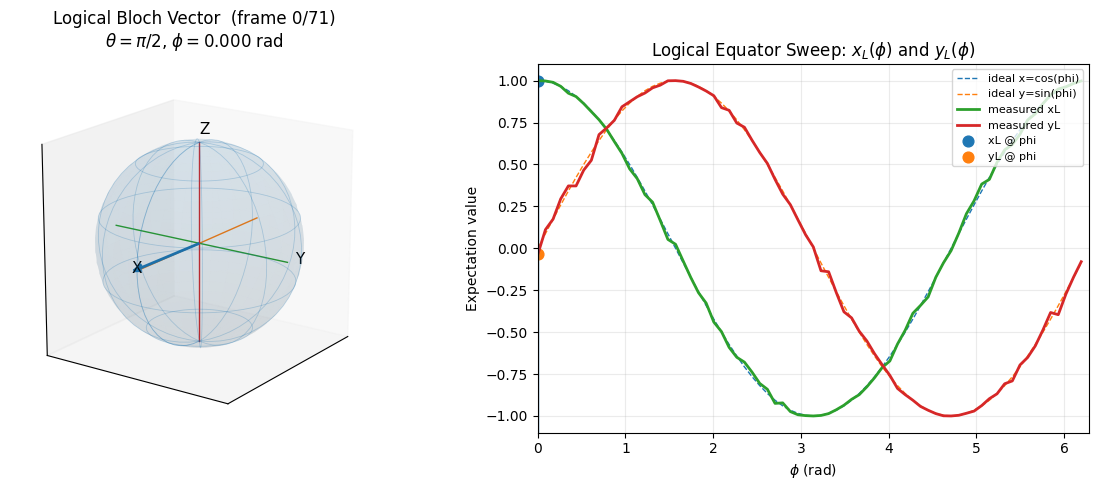

In [47]:
import numpy as np
import matplotlib.pyplot as plt

cache_path = "bloch_outputs/logical_bloch_equator_theta1.5708_shots2000_frames72.npz"
data = np.load(cache_path)

phis = data["phis"]
xL, yL, zL = data["xL"], data["yL"], data["zL"]
theta = float(data["theta"])
shots = int(data["shots"])

n_frames = len(phis)
print("Loaded:", cache_path)
print("frames:", n_frames, "shots:", shots, "theta:", theta)


def draw_bloch_sphere(ax, alpha=0.08, wire_alpha=0.25):
    # sphere surface
    u = np.linspace(0, 2*np.pi, 60)
    v = np.linspace(0, np.pi, 30)
    xs = np.outer(np.cos(u), np.sin(v))
    ys = np.outer(np.sin(u), np.sin(v))
    zs = np.outer(np.ones_like(u), np.cos(v))

    ax.plot_surface(xs, ys, zs, linewidth=0, alpha=alpha)
    ax.plot_wireframe(xs, ys, zs, rstride=6, cstride=6, linewidth=0.6, alpha=wire_alpha)

    # axes
    ax.plot([-1, 1], [0, 0], [0, 0], linewidth=1)
    ax.plot([0, 0], [-1, 1], [0, 0], linewidth=1)
    ax.plot([0, 0], [0, 0], [-1, 1], linewidth=1)

    ax.text(1.08, 0, 0, "X", fontsize=11)
    ax.text(0, 1.08, 0, "Y", fontsize=11)
    ax.text(0, 0, 1.08, "Z", fontsize=11)

    ax.set_xlim(-1.05, 1.05)
    ax.set_ylim(-1.05, 1.05)
    ax.set_zlim(-1.05, 1.05)
    ax.set_box_aspect((1,1,1))
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.view_init(elev=18, azim=35)

def make_static_frame(k=0):
    phi = phis[k]
    x, y, z = xL[k], yL[k], zL[k]

    fig = plt.figure(figsize=(12, 5))
    ax3 = fig.add_subplot(1, 2, 1, projection="3d")
    ax2 = fig.add_subplot(1, 2, 2)

    # --- Left: Bloch sphere + arrow ---
    draw_bloch_sphere(ax3)
    ax3.quiver(
        0, 0, 0, x, y, z,
        length=1.0, normalize=True, arrow_length_ratio=0.12,
        linewidth=2
    )
    ax3.set_title(f"Logical Bloch Vector  (frame {k}/{n_frames-1})\n"
                  f"$\\theta=\\pi/2$, $\\phi={phi:.3f}$ rad", pad=12)

    # --- Right: XY chart (xL and yL vs phi) ---
    x_id = np.cos(phis)
    y_id = np.sin(phis)

    ax2.plot(phis, x_id, linestyle="--", linewidth=1, label="ideal x=cos(phi)")
    ax2.plot(phis, y_id, linestyle="--", linewidth=1, label="ideal y=sin(phi)")

    ax2.plot(phis, xL, linewidth=2, label="measured xL")
    ax2.plot(phis, yL, linewidth=2, label="measured yL")

    # cursor + markers at current frame
    ax2.axvline(phi, linewidth=1)
    ax2.scatter([phi], [x], s=60, marker="o", label="xL @ phi")
    ax2.scatter([phi], [y], s=60, marker="o", label="yL @ phi")

    ax2.set_xlim(0, 2*np.pi)
    ax2.set_ylim(-1.1, 1.1)
    ax2.set_xlabel(r"$\phi$ (rad)")
    ax2.set_ylabel("Expectation value")
    ax2.set_title("Logical Equator Sweep: $x_L(\\phi)$ and $y_L(\\phi)$")
    ax2.grid(True, alpha=0.25)
    ax2.legend(loc="upper right", fontsize=8)

    fig.tight_layout()
    return fig

fig = make_static_frame(k=0)
plt.show()



In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from pathlib import Path

# Load cached sweep (use your existing cache path if different)
cache_path = "bloch_outputs/logical_bloch_equator_theta1.5708_shots2000_frames72.npz"
data = np.load(cache_path)

phis = data["phis"]
xL, yL, zL = data["xL"], data["yL"], data["zL"]
theta = float(data["theta"])
shots = int(data["shots"])
n_frames = len(phis)

out_dir = Path("bloch_outputs")
out_dir.mkdir(exist_ok=True)

def draw_bloch_sphere(ax, alpha=0.08, wire_alpha=0.25):
    u = np.linspace(0, 2*np.pi, 60)
    v = np.linspace(0, np.pi, 30)
    xs = np.outer(np.cos(u), np.sin(v))
    ys = np.outer(np.sin(u), np.sin(v))
    zs = np.outer(np.ones_like(u), np.cos(v))

    ax.plot_surface(xs, ys, zs, linewidth=0, alpha=alpha)
    ax.plot_wireframe(xs, ys, zs, rstride=6, cstride=6, linewidth=0.6, alpha=wire_alpha)

    ax.plot([-1, 1], [0, 0], [0, 0], linewidth=1)
    ax.plot([0, 0], [-1, 1], [0, 0], linewidth=1)
    ax.plot([0, 0], [0, 0], [-1, 1], linewidth=1)

    ax.text(1.08, 0, 0, "X", fontsize=11)
    ax.text(0, 1.08, 0, "Y", fontsize=11)
    ax.text(0, 0, 1.08, "Z", fontsize=11)

    ax.set_xlim(-1.05, 1.05)
    ax.set_ylim(-1.05, 1.05)
    ax.set_zlim(-1.05, 1.05)
    ax.set_box_aspect((1,1,1))
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.view_init(elev=18, azim=35)

# Figure sizing for slides: 1280x720 at dpi=100 -> figsize=(12.8, 7.2)
dpi = 100
fig = plt.figure(figsize=(12.8, 7.2), dpi=dpi)
ax3 = fig.add_subplot(1, 2, 1, projection="3d")
ax2 = fig.add_subplot(1, 2, 2)

# --- Left: Bloch sphere (static background) ---
draw_bloch_sphere(ax3)

# We'll render the "arrow" as a line + endpoint dot (fast and easy to update)
line3d, = ax3.plot([0, xL[0]], [0, yL[0]], [0, zL[0]], linewidth=3)
pt3d = ax3.scatter([xL[0]], [yL[0]], [zL[0]], s=60)

title3 = ax3.set_title("", pad=12)

# --- Right: XY chart (static lines) ---
x_id = np.cos(phis)
y_id = np.sin(phis)

ax2.plot(phis, x_id, linestyle="--", linewidth=1, label="ideal x=cos(phi)")
ax2.plot(phis, y_id, linestyle="--", linewidth=1, label="ideal y=sin(phi)")

ax2.plot(phis, xL, linewidth=2, label="measured xL")
ax2.plot(phis, yL, linewidth=2, label="measured yL")

cursor = ax2.axvline(phis[0], linewidth=1)
mx = ax2.scatter([phis[0]], [xL[0]], s=80, marker="o", label="xL @ phi")
my = ax2.scatter([phis[0]], [yL[0]], s=80, marker="o", label="yL @ phi")

ax2.set_xlim(0, 2*np.pi)
ax2.set_ylim(-1.1, 1.1)
ax2.set_xlabel(r"$\phi$ (rad)")
ax2.set_ylabel("Expectation value")
ax2.set_title("Logical Equator Sweep: $x_L(\\phi)$ and $y_L(\\phi)$")
ax2.grid(True, alpha=0.25)
ax2.legend(loc="upper right", fontsize=9)

fig.tight_layout()
plt.close(fig)  # prevents duplicate static display in notebooks


In [49]:
def update(k):
    phi = float(phis[k])
    x, y, z = float(xL[k]), float(yL[k]), float(zL[k])

    # Update 3D "arrow" line
    line3d.set_data([0, x], [0, y])
    line3d.set_3d_properties([0, z])

    # Update endpoint dot
    pt3d._offsets3d = ([x], [y], [z])

    # Update title
    title3.set_text(
        f"Logical Bloch Vector (noiseless sampling)\n"
        f"$\\theta=\\pi/2$, $\\phi={phi:.3f}$ rad   shots={shots}"
    )

    # Update XY cursor + markers
    cursor.set_xdata([phi, phi])
    mx.set_offsets(np.array([[phi, x]]))
    my.set_offsets(np.array([[phi, y]]))

    

    return (line3d, pt3d, title3, cursor, mx, my)

fps = 18  # good for slides; increase to 24 if you want smoother
anim = animation.FuncAnimation(fig, update, frames=n_frames, interval=1000/fps, blit=False)

gif_path = out_dir / "logical_bloch_equator.gif"
writer = animation.PillowWriter(fps=fps)

anim.save(gif_path, writer=writer)
gif_path



PosixPath('bloch_outputs/logical_bloch_equator.gif')

In [50]:
# from IPython.display import Image, display
# display(Image(filename=str(gif_path)))


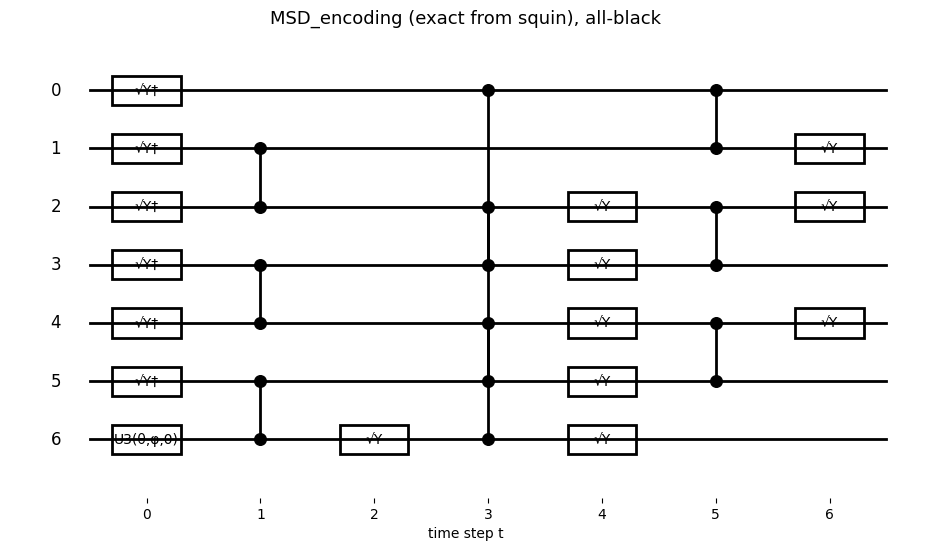

In [51]:
# ===== Section 1 (updated): exact timeline from your squin code, all-black drawing =====
from dataclasses import dataclass
from typing import Tuple, List, Optional
import matplotlib.pyplot as plt

@dataclass(frozen=True)
class Op:
    t: int
    name: str                  # "u3", "sy", "sydg", "cz"
    qubits: Tuple[int, ...]
    params: Optional[Tuple] = None  # e.g. ("theta","phi",0)

def validate_ops(ops: List[Op], n_qubits: int = 7):
    for op in ops:
        assert all(0 <= q < n_qubits for q in op.qubits), f"Bad qubit index in {op}"
        assert len(set(op.qubits)) == len(op.qubits), f"Repeated qubit in {op}"
        if op.name == "cz":
            assert len(op.qubits) == 2, f"CZ must have 2 qubits: {op}"
        elif op.name in ("sy", "sydg", "u3"):
            assert len(op.qubits) == 1, f"{op.name} must have 1 qubit: {op}"
        else:
            raise ValueError(f"Unknown gate {op.name}")

def draw_timeline(ops: List[Op], n_qubits: int = 7, title: str = "Circuit (timeline sketch)"):
    T = (max(op.t for op in ops) + 1) if ops else 1
    fig, ax = plt.subplots(figsize=(1.25*T + 3, 0.65*n_qubits + 1.5))

    # wires (force black)
    for q in range(n_qubits):
        y = (n_qubits - 1 - q)
        ax.plot([-0.5, T-0.5], [y, y], linewidth=2, color="k")
        ax.text(-0.75, y, str(q), va="center", ha="right", fontsize=12, color="k")

    # gates (force black)
    for op in ops:
        x = op.t
        if op.name in ("sy", "sydg", "u3"):
            (q,) = op.qubits
            y = (n_qubits - 1 - q)
            rect = plt.Rectangle((x-0.30, y-0.25), 0.60, 0.50, fill=False, linewidth=2, edgecolor="k")
            ax.add_patch(rect)
            if op.name == "u3":
                label = "U3(θ,φ,0)"
            else:
                label = "√Y" + ("†" if op.name == "sydg" else "")
            ax.text(x, y, label, ha="center", va="center", fontsize=10, color="k")
        elif op.name == "cz":
            q1, q2 = op.qubits
            y1 = (n_qubits - 1 - q1)
            y2 = (n_qubits - 1 - q2)
            ax.plot([x, x], [y1, y2], linewidth=2, color="k")
            ax.scatter([x, x], [y1, y2], s=70, c="k")
        else:
            raise ValueError(f"Unknown gate {op.name}")

    ax.set_title(title, fontsize=13, color="k")
    ax.set_xlim(-1.2, T-0.2)
    ax.set_ylim(-1, n_qubits)
    ax.set_xticks(range(T))
    ax.set_xlabel("time step t", color="k")
    ax.tick_params(axis='x', colors='k')
    ax.set_yticks([])
    ax.set_frame_on(False)
    plt.show()

# === Exact circuit from your squin code ===
OPS: List[Op] = []

# t=0: prepare |ψ(θ,φ)> on q6 + sqrt_y_adj on q0..q5
OPS += [Op(0, "u3",   (6,), params=("theta", "phi", 0))]
OPS += [Op(0, "sydg", (q,)) for q in range(6)]

# t=1: CZ(1,2), CZ(3,4), CZ(5,6)
OPS += [Op(1, "cz", (1,2)), Op(1, "cz", (3,4)), Op(1, "cz", (5,6))]

# t=2: sqrt_y on q6
OPS += [Op(2, "sy", (6,))]

# t=3: CZ(0,3), CZ(2,5), CZ(4,6)
OPS += [Op(3, "cz", (0,3)), Op(3, "cz", (2,5)), Op(3, "cz", (4,6))]

# t=4: sqrt_y on q2..q6
OPS += [Op(4, "sy", (q,)) for q in (2,3,4,5,6)]

# t=5: CZ(0,1), CZ(2,3), CZ(4,5)
OPS += [Op(5, "cz", (0,1)), Op(5, "cz", (2,3)), Op(5, "cz", (4,5))]

# t=6: sqrt_y on q1, q2, q4
OPS += [Op(6, "sy", (q,)) for q in (1,2,4)]

validate_ops(OPS, n_qubits=7)
draw_timeline(OPS, n_qubits=7, title="MSD_encoding (exact from squin), all-black")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# --- Pauli frame using symplectic bits per qubit: I=(0,0), X=(1,0), Z=(0,1), Y=(1,1)
PAULI_FROM_BITS = {(0,0):"I", (1,0):"X", (0,1):"Z", (1,1):"Y"}

class PauliFrame:
    def __init__(self, n: int):
        self.n = n
        self.x = np.zeros(n, dtype=np.uint8)
        self.z = np.zeros(n, dtype=np.uint8)

    def copy(self):
        pf = PauliFrame(self.n)
        pf.x[:] = self.x
        pf.z[:] = self.z
        return pf

    def inject(self, pauli: str, q: int):
        p = pauli.upper()
        if p == "I": return
        if p == "X": self.x[q] ^= 1
        elif p == "Z": self.z[q] ^= 1
        elif p == "Y":
            self.x[q] ^= 1
            self.z[q] ^= 1
        else:
            raise ValueError("pauli must be one of I/X/Y/Z")

    # sqrt_y and sqrt_y_adj both swap X <-> Z (ignoring global phase), Y stays Y.
    def through_sy(self, q: int):
        self.x[q], self.z[q] = self.z[q], self.x[q]

    def through_sydg(self, q: int):
        self.x[q], self.z[q] = self.z[q], self.x[q]

    # CZ(a,b): z[a] ^= x[b], z[b] ^= x[a]
    def through_cz(self, a: int, b: int):
        xa, xb = self.x[a], self.x[b]
        self.z[a] ^= xb
        self.z[b] ^= xa

    def labels(self):
        return [PAULI_FROM_BITS[(int(self.x[q]), int(self.z[q]))] for q in range(self.n)]


def group_by_t(OPS):
    Tmax = max(op.t for op in OPS) + 1
    layers = [[] for _ in range(Tmax)]
    for op in OPS:
        layers[op.t].append(op)
    return layers

def op_matches(op, name: str, qubits: tuple):
    if op.name != name: return False
    return tuple(op.qubits) == tuple(qubits)

def build_frames_pauli_propagation(
    OPS,
    inject_after={"name":"cz","qubits":(1,2)},  # location: after this gate
    inject_error={"pauli":"Z","qubit":2},       # what error to inject
):
    n = 7
    layers = group_by_t(OPS)
    Tmax = len(layers)

    pf = PauliFrame(n)
    frames = []

    injected = False

    # Frame 0: show circuit with no error
    frames.append({"phase":"pre", "t":0, "labels":pf.labels(), "highlight":None, "note":"no error"})

    for t in range(Tmax):
        # BEFORE layer t
        frames.append({"phase":"before", "t":t, "labels":pf.labels(), "highlight":t,
                       "note":f"before t={t}"})

        # Walk ops inside this layer in-order; inject immediately AFTER the matching op.
        for op in layers[t]:
            # propagate existing error through this op (Heisenberg update E -> U E U†)
            if op.name == "sy":
                pf.through_sy(op.qubits[0])
            elif op.name == "sydg":
                pf.through_sydg(op.qubits[0])
            elif op.name == "cz":
                pf.through_cz(op.qubits[0], op.qubits[1])
            elif op.name == "u3":
                # not Clifford; for Pauli-frame propagation we ignore it (it prepares the state).
                pass
            else:
                raise ValueError(f"Unknown op {op.name}")

            # inject after the specified gate
            if (not injected) and op_matches(op, inject_after["name"], inject_after["qubits"]):
                pf.inject(inject_error["pauli"], int(inject_error["qubit"]))
                injected = True
                frames.append({
                    "phase":"inject",
                    "t":t,
                    "labels":pf.labels(),
                    "highlight":t,
                    "note":f"INJECT {inject_error['pauli'].upper()} on q{inject_error['qubit']} after {inject_after['name']} {inject_after['qubits']}"
                })

        # AFTER layer t
        frames.append({"phase":"after", "t":t, "labels":pf.labels(), "highlight":t,
                       "note":f"after t={t}"})

    if not injected:
        raise ValueError("Injection gate not found in OPS. Check inject_after spec.")
    return frames, Tmax


def draw_circuit_with_labels(ax, OPS, labels, highlight_t=None, note=""):
    n_qubits = 7
    T = (max(op.t for op in OPS) + 1) if OPS else 1

    # wires
    for q in range(n_qubits):
        y = (n_qubits - 1 - q)
        ax.plot([-0.5, T-0.5], [y, y], linewidth=2, color="k")

    # gates
    for op in OPS:
        x = op.t
        if op.name in ("sy", "sydg", "u3"):
            (q,) = op.qubits
            y = (n_qubits - 1 - q)
            edge = "k" if highlight_t is None or op.t != highlight_t else "tab:red"
            lw = 2 if edge == "k" else 3
            rect = plt.Rectangle((x-0.30, y-0.25), 0.60, 0.50, fill=False, linewidth=lw, edgecolor=edge)
            ax.add_patch(rect)
            if op.name == "u3":
                label = "U3"
            else:
                label = "√Y" + ("†" if op.name == "sydg" else "")
            ax.text(x, y, label, ha="center", va="center", fontsize=10, color=edge)
        elif op.name == "cz":
            q1, q2 = op.qubits
            y1 = (n_qubits - 1 - q1)
            y2 = (n_qubits - 1 - q2)
            col = "k" if highlight_t is None or op.t != highlight_t else "tab:red"
            lw = 2 if col == "k" else 3
            ax.plot([x, x], [y1, y2], linewidth=lw, color=col)
            ax.scatter([x, x], [y1, y2], s=70, c=col)
        else:
            pass

    # qubit labels + current Pauli error labels on the LEFT of the current highlighted column
    x_text = (-0.75 if highlight_t is None else highlight_t - 0.45)
    for q in range(n_qubits):
        y = (n_qubits - 1 - q)
        ax.text(-0.9, y, str(q), va="center", ha="right", fontsize=12, color="k")
        ax.text(x_text, y+0.32, labels[q], va="center", ha="center",
                fontsize=11, color=("tab:red" if labels[q] != "I" else "0.35"))

    ax.set_title(note, fontsize=12)
    ax.set_xlim(-1.2, T-0.2)
    ax.set_ylim(-1, n_qubits)
    ax.set_xticks(range(T))
    ax.set_yticks([])
    ax.set_frame_on(False)


def animate_error_propagation(OPS, inject_after, inject_error, interval_ms=650):
    frames, Tmax = build_frames_pauli_propagation(OPS, inject_after=inject_after, inject_error=inject_error)

    fig, ax = plt.subplots(figsize=(11, 6))

    def update(i):
        ax.clear()
        f = frames[i]
        draw_circuit_with_labels(ax, OPS, f["labels"], highlight_t=f["highlight"], note=f["note"])

    anim = FuncAnimation(fig, update, frames=len(frames), interval=interval_ms, repeat=True)
    plt.close(fig)
    return anim

# === Example: "CZ error on bit two of the first CZ gate" interpreted as Z on q2 after CZ(1,2)
anim = animate_error_propagation(
    OPS,
    inject_after={"name":"cz","qubits":(1,2)},
    inject_error={"pauli":"Z","qubit":2},
    interval_ms=700
)

HTML(anim.to_jshtml())


In [57]:
# --- Widgets + "time-based injection" wrapper ---
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

def _choose_injected_pauli(model, theta, phi, p, manual_pauli, rng):
    """
    Returns (pauli_str, extra_note).
    p in [0,1] is "total error probability" (prob of non-identity) for stochastic models.
    """
    model = model.lower()
    if model == "manual":
        return manual_pauli, f"manual {manual_pauli}"

    # Dephasing: I w.p. (1-p), Z w.p. p
    if model == "dephasing(z)":
        pauli = rng.choice(["I", "Z"], p=[1 - p, p])
        return pauli, f"dephasing p={p:.3f}"

    # Depolarizing: I w.p. (1-p), X/Y/Z each w.p. p/3
    if model == "depolarizing":
        pauli = rng.choice(["I", "X", "Y", "Z"], p=[1 - p, p/3, p/3, p/3])
        return pauli, f"depol p={p:.3f}"

    # Coherent axis rotation (Pauli-twirled):
    # With total non-identity probability p, distribute across X/Y/Z by axis components squared.
    # Axis: n = (sinθ cosφ, sinθ sinφ, cosθ)
    if model == "coherent(axis)":
        nx = np.sin(theta) * np.cos(phi)
        ny = np.sin(theta) * np.sin(phi)
        nz = np.cos(theta)

        w = np.array([nx*nx, ny*ny, nz*nz], dtype=float)
        s = w.sum()
        if s == 0:
            w = np.array([1.0, 0.0, 0.0])
        else:
            w /= s

        probs = np.array([1 - p, p*w[0], p*w[1], p*w[2]], dtype=float)
        probs = np.clip(probs, 0, 1)
        probs /= probs.sum()  # renormalize

        pauli = rng.choice(["I", "X", "Y", "Z"], p=probs)
        return pauli, f"axis-twirl p={p:.3f}, (pX,pY,pZ)=({probs[1]:.3f},{probs[2]:.3f},{probs[3]:.3f})"

    raise ValueError(f"Unknown error model: {model}")

def build_frames_pauli_propagation_time(
    OPS,
    inject_time: int,                  # inject after finishing layer t=inject_time
    inject_error: dict,                # {"pauli": "X/Y/Z/I", "qubit": int}
):
    n = 7
    layers = group_by_t(OPS)
    Tmax = len(layers)

    if not (0 <= inject_time < Tmax):
        raise ValueError(f"inject_time must be in [0, {Tmax-1}]")

    pf = PauliFrame(n)
    frames = []

    frames.append({"phase":"pre", "t":0, "labels":pf.labels(), "highlight":None, "note":"no error"})

    injected = False

    for t in range(Tmax):
        frames.append({"phase":"before", "t":t, "labels":pf.labels(), "highlight":t, "note":f"before t={t}"})

        for op in layers[t]:
            if op.name == "sy":
                pf.through_sy(op.qubits[0])
            elif op.name == "sydg":
                pf.through_sydg(op.qubits[0])
            elif op.name == "cz":
                pf.through_cz(op.qubits[0], op.qubits[1])
            elif op.name == "u3":
                pass
            else:
                raise ValueError(f"Unknown op {op.name}")

        # inject AFTER the whole layer at the selected time
        if (not injected) and (t == inject_time):
            pf.inject(inject_error["pauli"], int(inject_error["qubit"]))
            injected = True
            frames.append({
                "phase":"inject",
                "t":t,
                "labels":pf.labels(),
                "highlight":t,
                "note":f"INJECT {inject_error['pauli']} on q{inject_error['qubit']} after layer t={t}"
            })

        frames.append({"phase":"after", "t":t, "labels":pf.labels(), "highlight":t, "note":f"after t={t}"})

    return frames, Tmax

def animate_error_propagation_time(OPS, inject_time, inject_error, interval_ms=650):
    frames, _ = build_frames_pauli_propagation_time(OPS, inject_time=inject_time, inject_error=inject_error)
    fig, ax = plt.subplots(figsize=(11, 6))

    def update(i):
        ax.clear()
        f = frames[i]
        draw_circuit_with_labels(ax, OPS, f["labels"], highlight_t=f["highlight"], note=f["note"])

    anim = FuncAnimation(fig, update, frames=len(frames), interval=interval_ms, repeat=True)
    plt.close(fig)
    return anim

def pauli_propagation_ui_fixed(OPS, interval_ms=650, seed=0):
    """
    Widget UI for Pauli-frame propagation.

    Key fix vs your original:
      - RNG is created ONCE and reused across renders (no re-seeding every slider change),
        so stochastic models will not get stuck always sampling the same Pauli (often 'I').
    """
    Tmax = max(op.t for op in OPS) + 1

    # --- Controls
    theta = widgets.FloatSlider(value=np.pi/2, min=0.0, max=np.pi, step=0.01,
                                description="θ", readout_format=".2f")
    phi   = widgets.FloatSlider(value=0.0,     min=0.0, max=2*np.pi, step=0.01,
                                description="φ", readout_format=".2f")
    p     = widgets.FloatSlider(value=0.2,     min=0.0, max=1.0, step=0.01,
                                description="noise", readout_format=".2f")
    t     = widgets.IntSlider(value=0,         min=0,   max=Tmax-1, step=1,
                              description="t_err")
    q     = widgets.IntSlider(value=0,         min=0,   max=6, step=1,
                              description="qubit")
    model = widgets.Dropdown(options=["manual", "dephasing(Z)", "depolarizing", "coherent(axis)"],
                             value="coherent(axis)", description="err type")
    manual_pauli = widgets.Dropdown(options=["X","Y","Z"], value="Z", description="Pauli")

    out = widgets.Output()

    # --- FIX: RNG persists across all renders
    rng = np.random.default_rng(seed)

    def _render(*_):
        pauli, note = _choose_injected_pauli(
            model.value, theta.value, phi.value, p.value, manual_pauli.value, rng
        )

        with out:
            clear_output(wait=True)

            anim = animate_error_propagation_time(
                OPS,
                inject_time=int(t.value),
                inject_error={"pauli": pauli, "qubit": int(q.value)},
                interval_ms=interval_ms,
            )

            # Debug line: makes it obvious if you sampled I (no error)
            display(widgets.HTML(
                f"<b>{note}</b> &nbsp; | &nbsp; sampled=<b>{pauli}</b> "
                f"&nbsp; | &nbsp; t_err={int(t.value)}, qubit={int(q.value)}"
            ))
            display(HTML(anim.to_jshtml()))

    # observe
    for w in (theta, phi, p, t, q, model, manual_pauli):
        w.observe(_render, names="value")

    controls = widgets.VBox([
        widgets.HBox([model, manual_pauli]),
        widgets.HBox([theta, phi]),
        widgets.HBox([p, t, q]),
    ])

    display(controls, out)
    _render()

# Run this once:
pauli_propagation_ui_fixed(OPS, interval_ms=700, seed=0)

Output()

In [59]:
from matplotlib.animation import PillowWriter

# anim is your FuncAnimation object
# interval_ms should match what you used in FuncAnimation
interval_ms = 700

fps = 1000 / interval_ms  # frames per second that matches interval

anim.save(
    "pauli_propagation.gif",
    writer=PillowWriter(fps=fps)
)
print("Saved pauli_propagation.gif with fps =", fps)


Saved pauli_propagation.gif with fps = 1.4285714285714286
